# Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
!pip install htmldate
from htmldate import find_date
import urllib.request
import re
from urllib.request import urlopen
from urllib.error import HTTPError
import csv

In [2]:
article_data = pd.read_csv('file.csv')
article_data.head()

,Unnamed: 0,link
0,Article 1,https://www.channelnewsasia.com/business/count...
1,Article 2,https://www.channelnewsasia.com/commentary/chi...
2,Article 3,https://www.channelnewsasia.com/asia/china-eco...
3,Article 4,https://www.channelnewsasia.com/cna-insider/ch...
4,Article 5,https://www.channelnewsasia.com/commentary/chi...


In [3]:
news_links = list(article_data["link"])

In [4]:
count = 0
articles_array = []
for link in news_links:
    try:
        # Get article link
        url = news_links[count]
        webUrl = urllib.request.urlopen(url)
        data = webUrl.read()

        # Get title of the article
        page = urlopen(url)
        html = page.read().decode("utf-8")
        pattern = "<title.*?>.*?</title.*?>"
        match_results = re.search(pattern, html, re.IGNORECASE)
        title = match_results.group()
        title = re.sub("<.*?>", "", title) # Remove HTML tags

        # Get the article's content
        page = urlopen(url)
        html = page.read().decode("utf-8")
        soup = BeautifulSoup(html, "html.parser")
        content = soup.get_text().replace('\n', '')
        text = ' '.join(content.split())

        # Get article's published date
        date = find_date(data)

        # Combine all details of an article
        article = {}
        article['Title'] = title
        article['Date'] = date
        article['Link'] = url
        article['Text'] = text
        articles_array.append(article)
    except HTTPError:
        pass
    
    count = count + 1

In [5]:
# Save article as CSV-file
try:
    f = csv.writer(open('cna_dataset.csv', 'w', encoding='utf-8'))
    f.writerow(['Title','PublishedDate', 'Link', 'Text'])
    for article_details in articles_array:
        title = article_details['Title']
        date = article_details['Date']
        link = article_details['Link']
        text = article_details['Text']
        f.writerow([title, date, link, text])
except Exception as e: print(e)

In [6]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import networkx as nx
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
import spacy
import datetime

In [7]:
df = pd.read_csv('/Users/richardreynard/Downloads/SC3901/ChinaHousingMarket/cna_dataset.csv')
df.head()

,Title,PublishedDate,Link,Text
0,"Country Garden, Sunac debt deals bring respite...",2023-09-19,https://www.channelnewsasia.com/business/count...,"Country Garden, Sunac debt deals bring respite..."
1,Commentary: Why China’s real estate crisis sho...,2023-09-16,https://www.channelnewsasia.com/commentary/chi...,Commentary: Why China’s real estate crisis sho...
2,China’s economic data shows signs of life amid...,2023-09-15,https://www.channelnewsasia.com/asia/china-eco...,China’s economic data shows signs of life amid...
3,She has a master’s but no job and lives on dis...,2023-09-09,https://www.channelnewsasia.com/cna-insider/ch...,She has a master’s but no job and lives on dis...
4,Commentary: Is China finally getting serious a...,2023-09-08,https://www.channelnewsasia.com/commentary/chi...,Commentary: Is China finally getting serious a...


In [8]:
print(f"Total number of rows: {len(df)}")

Total number of rows: 105


In [9]:
advertisement_rows = sum(len(str(row['Text']).split()) < 200 for _, row in df.iterrows())
print(f"Number of rows that might be an advertisement: {advertisement_rows}")

Number of rows that might be an advertisement: 0


In [10]:
import csv

# specify the column to check and update
column_to_check = 'Text'

# open the input CSV file
with open('/Users/richardreynard/Downloads/SC3901/ChinaHousingMarket/cna_dataset.csv', 'r') as input_file:
    # create a CSV reader object
    reader = csv.DictReader(input_file)

    # open the output CSV file
    with open('new_cna_dataset.csv', 'w', newline='') as output_file:
        # create a CSV writer object
        writer = csv.DictWriter(output_file, fieldnames=reader.fieldnames)
        writer.writeheader()

        # iterate over the rows in the input CSV
        for row in reader:
            # check the length of the column
            if len(row[column_to_check].split()) < 200:
                continue
            
            # read the specified column
            text = row[column_to_check]

            # remove extra spaces between words and newlines
            text = ' '.join(text.split())
            text = text.replace('\n', ' ')

            # update the row with the cleaned text
            row[column_to_check] = text
            
            # remove duplicated rows
            df = df[df.shift() != df].dropna()

            # write the updated row to the output CSV
            writer.writerow(row)

In [11]:
df = pd.read_csv('/Users/richardreynard/Downloads/SC3901/ChinaHousingMarket/new_cna_dataset.csv')
df.head()

,Title,PublishedDate,Link,Text
0,"Country Garden, Sunac debt deals bring respite...",2023-09-19,https://www.channelnewsasia.com/business/count...,"Country Garden, Sunac debt deals bring respite..."
1,Commentary: Why China’s real estate crisis sho...,2023-09-16,https://www.channelnewsasia.com/commentary/chi...,Commentary: Why China’s real estate crisis sho...
2,China’s economic data shows signs of life amid...,2023-09-15,https://www.channelnewsasia.com/asia/china-eco...,China’s economic data shows signs of life amid...
3,She has a master’s but no job and lives on dis...,2023-09-09,https://www.channelnewsasia.com/cna-insider/ch...,She has a master’s but no job and lives on dis...
4,Commentary: Is China finally getting serious a...,2023-09-08,https://www.channelnewsasia.com/commentary/chi...,Commentary: Is China finally getting serious a...


In [12]:
df['Text'] = df['Text'].apply(lambda txt: txt.lower())
stop_words=stopwords.words('english')
df['Text'] = df['Text'].apply(lambda txt: ' '.join([word for word in txt.split() if word not in stop_words]))
df['Text'] = df['Text'].apply(lambda txt: sent_tokenize(txt))
df['Text'] = df['Text'].apply(lambda txt: ' '.join(txt))

In [13]:
df.head()

,Title,PublishedDate,Link,Text
0,"Country Garden, Sunac debt deals bring respite...",2023-09-19,https://www.channelnewsasia.com/business/count...,"country garden, sunac debt deals bring respite..."
1,Commentary: Why China’s real estate crisis sho...,2023-09-16,https://www.channelnewsasia.com/commentary/chi...,commentary: china’s real estate crisis make gl...
2,China’s economic data shows signs of life amid...,2023-09-15,https://www.channelnewsasia.com/asia/china-eco...,china’s economic data shows signs life amid pr...
3,She has a master’s but no job and lives on dis...,2023-09-09,https://www.channelnewsasia.com/cna-insider/ch...,"master’s job lives discount coupons. china, ma..."
4,Commentary: Is China finally getting serious a...,2023-09-08,https://www.channelnewsasia.com/commentary/chi...,commentary: china finally getting serious huko...


In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [15]:
df['score'] = df['Text'].apply(lambda txt: sid.polarity_scores(txt))

In [16]:
df['negative'] = df['score'].apply(lambda txt: txt['neg'])
df['neutral'] = df['score'].apply(lambda txt: txt['neu'])
df['positive'] = df['score'].apply(lambda txt: txt['pos'])
df['compound'] = df['score'].apply(lambda txt: txt['compound'])

In [17]:
def polarity_score(compound):
    if compound > 0.05:
        return "positive"
    elif compound < -0.05:
        return "negative"
    elif compound >= -0.05 and compound < 0.05:
        return "neutral"

In [18]:
df['sentiment'] = df['compound'].apply(lambda val: polarity_score(val))
df

,Title,PublishedDate,Link,Text,score,negative,neutral,positive,compound,sentiment
0,"Country Garden, Sunac debt deals bring respite...",2023-09-19,https://www.channelnewsasia.com/business/count...,"country garden, sunac debt deals bring respite...","{'neg': 0.068, 'neu': 0.809, 'pos': 0.123, 'co...",0.068,0.809,0.123,0.9917,positive
1,Commentary: Why China’s real estate crisis sho...,2023-09-16,https://www.channelnewsasia.com/commentary/chi...,commentary: china’s real estate crisis make gl...,"{'neg': 0.109, 'neu': 0.805, 'pos': 0.087, 'co...",0.109,0.805,0.087,-0.9653,negative
2,China’s economic data shows signs of life amid...,2023-09-15,https://www.channelnewsasia.com/asia/china-eco...,china’s economic data shows signs life amid pr...,"{'neg': 0.088, 'neu': 0.806, 'pos': 0.106, 'co...",0.088,0.806,0.106,0.9718,positive
3,She has a master’s but no job and lives on dis...,2023-09-09,https://www.channelnewsasia.com/cna-insider/ch...,"master’s job lives discount coupons. china, ma...","{'neg': 0.071, 'neu': 0.834, 'pos': 0.095, 'co...",0.071,0.834,0.095,0.9910,positive
4,Commentary: Is China finally getting serious a...,2023-09-08,https://www.channelnewsasia.com/commentary/chi...,commentary: china finally getting serious huko...,"{'neg': 0.059, 'neu': 0.829, 'pos': 0.112, 'co...",0.059,0.829,0.112,0.9956,positive
...,...,...,...,...,...,...,...,...,...,...
100,Commentary: China needs bolder moves for growt...,2021-10-27,https://www.channelnewsasia.com/commentary/chi...,commentary: china needs bolder moves growth en...,"{'neg': 0.14, 'neu': 0.723, 'pos': 0.138, 'com...",0.140,0.723,0.138,-0.9780,negative
101,Commentary: Evergrande woes show China’s overr...,2021-09-30,https://www.channelnewsasia.com/commentary/eve...,commentary: evergrande woes show china’s overr...,"{'neg': 0.082, 'neu': 0.798, 'pos': 0.121, 'co...",0.082,0.798,0.121,0.9867,positive
102,Commentary: China’s leaders risk a dangerous m...,2021-09-29,https://www.channelnewsasia.com/commentary/eve...,commentary: china’s leaders risk dangerous mis...,"{'neg': 0.125, 'neu': 0.765, 'pos': 0.11, 'com...",0.125,0.765,0.110,-0.9738,negative
103,China asking state-backed firms to pick up Eve...,2021-09-28,https://www.channelnewsasia.com/business/china...,china asking state-backed firms pick evergrand...,"{'neg': 0.046, 'neu': 0.852, 'pos': 0.103, 'co...",0.046,0.852,0.103,0.9907,positive


In [19]:
df['PublishedDate'] = pd.to_datetime(df['PublishedDate'], format = '%Y-%m-%d')

In [20]:
df.sort_values(by='PublishedDate', inplace = True)
df

,Title,PublishedDate,Link,Text,score,negative,neutral,positive,compound,sentiment
104,Evergrande pain spreads to wealthy investors a...,2021-09-27,https://www.channelnewsasia.com/business/everg...,evergrande pain spreads wealthy investors inte...,"{'neg': 0.087, 'neu': 0.765, 'pos': 0.148, 'co...",0.087,0.765,0.148,0.9981,positive
103,China asking state-backed firms to pick up Eve...,2021-09-28,https://www.channelnewsasia.com/business/china...,china asking state-backed firms pick evergrand...,"{'neg': 0.046, 'neu': 0.852, 'pos': 0.103, 'co...",0.046,0.852,0.103,0.9907,positive
102,Commentary: China’s leaders risk a dangerous m...,2021-09-29,https://www.channelnewsasia.com/commentary/eve...,commentary: china’s leaders risk dangerous mis...,"{'neg': 0.125, 'neu': 0.765, 'pos': 0.11, 'com...",0.125,0.765,0.110,-0.9738,negative
101,Commentary: Evergrande woes show China’s overr...,2021-09-30,https://www.channelnewsasia.com/commentary/eve...,commentary: evergrande woes show china’s overr...,"{'neg': 0.082, 'neu': 0.798, 'pos': 0.121, 'co...",0.082,0.798,0.121,0.9867,positive
100,Commentary: China needs bolder moves for growt...,2021-10-27,https://www.channelnewsasia.com/commentary/chi...,commentary: china needs bolder moves growth en...,"{'neg': 0.14, 'neu': 0.723, 'pos': 0.138, 'com...",0.140,0.723,0.138,-0.9780,negative
...,...,...,...,...,...,...,...,...,...,...
62,Will China’s property headaches have broader e...,2023-10-05,https://www.channelnewsasia.com/asia/china-pro...,china’s property headaches broader economic ef...,"{'neg': 0.071, 'neu': 0.831, 'pos': 0.098, 'co...",0.071,0.831,0.098,0.9707,positive
61,Analysis:Evergrande crisis tests Beijing&#039;...,2023-10-05,https://www.channelnewsasia.com/business/analy...,analysis:evergrande crisis tests beijing's fal...,"{'neg': 0.11, 'neu': 0.796, 'pos': 0.093, 'com...",0.110,0.796,0.093,-0.9677,negative
60,Wall St brokerages raise China&#039;s economic...,2023-10-05,https://www.channelnewsasia.com/business/wall-...,wall st brokerages raise china's economic grow...,"{'neg': 0.059, 'neu': 0.8, 'pos': 0.141, 'comp...",0.059,0.800,0.141,0.9918,positive
59,Chinese developer Country Garden faces fresh o...,2023-10-09,https://www.channelnewsasia.com/business/china...,chinese developer country garden faces fresh o...,"{'neg': 0.068, 'neu': 0.819, 'pos': 0.113, 'co...",0.068,0.819,0.113,0.9841,positive


In [21]:
sentiment_index = df[['PublishedDate', 'compound']]
sentiment_index

,PublishedDate,compound
104,2021-09-27,0.9981
103,2021-09-28,0.9907
102,2021-09-29,-0.9738
101,2021-09-30,0.9867
100,2021-10-27,-0.9780
...,...,...
62,2023-10-05,0.9707
61,2023-10-05,-0.9677
60,2023-10-05,0.9918
59,2023-10-09,0.9841


In [22]:
si_group = sentiment_index.groupby('PublishedDate')['PublishedDate'].count()
print(si_group)

PublishedDate
2021-09-27    1
2021-09-28    1
2021-09-29    1
2021-09-30    1
2021-10-27    1
             ..
2023-10-03    1
2023-10-04    1
2023-10-05    3
2023-10-09    1
2023-10-10    1
Name: PublishedDate, Length: 81, dtype: int64


In [23]:
si_mean = sentiment_index.groupby('PublishedDate').compound.agg(['mean']).reset_index()
si_mean = si_mean.rename(columns={'mean':'SentimentScore'})
si_mean

,PublishedDate,SentimentScore
0,2021-09-27,0.9981
1,2021-09-28,0.9907
2,2021-09-29,-0.9738
3,2021-09-30,0.9867
4,2021-10-27,-0.9780
...,...,...
76,2023-10-03,0.4381
77,2023-10-04,0.9946
78,2023-10-05,0.3316
79,2023-10-09,0.9841


<Figure size 1600x400 with 0 Axes>

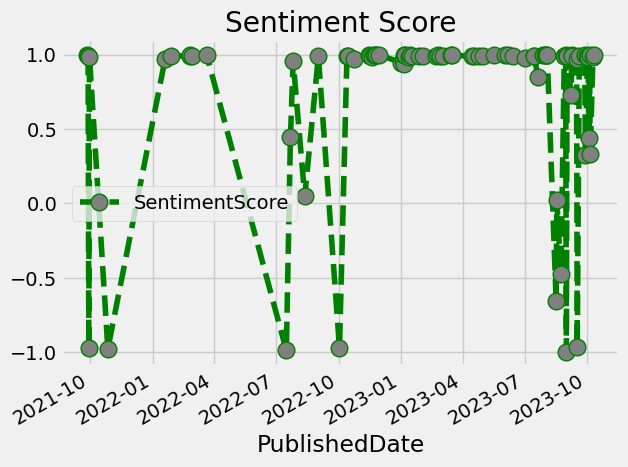

In [24]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.figure(figsize=(16, 4))
si_mean.plot(x='PublishedDate', y='SentimentScore', color='green', linestyle = 'dashed', title='Sentiment Score', marker='o', markerfacecolor='gray', markersize=12)
plt.show()

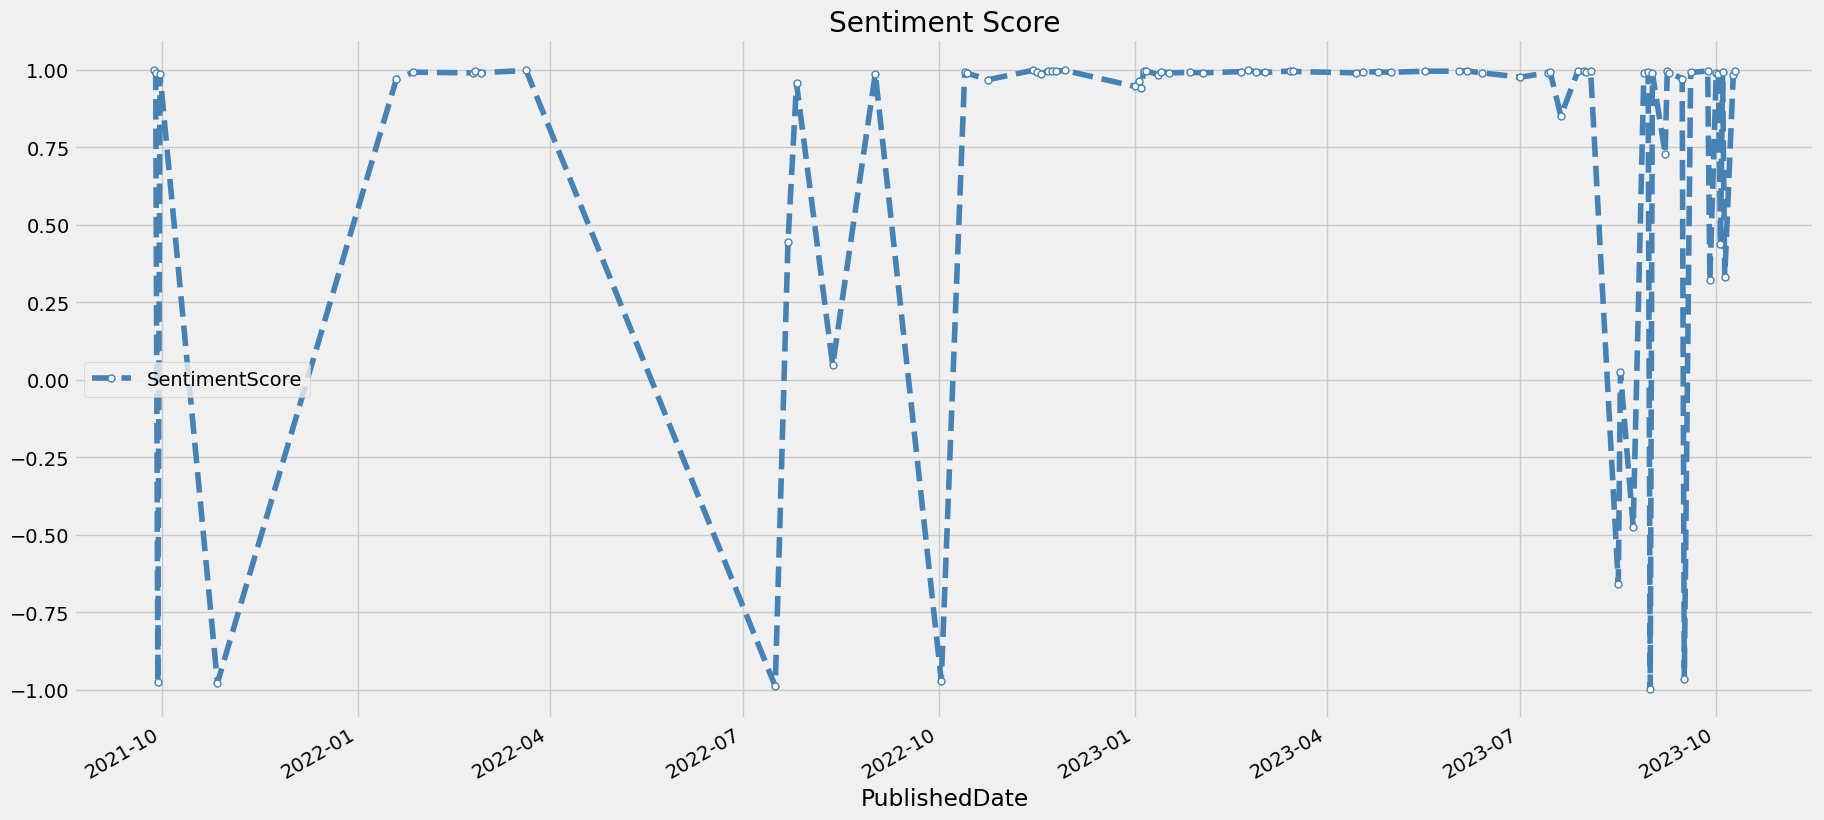

In [25]:
fig, ax = plt.subplots(figsize=(20,10))
si_mean.plot(x='PublishedDate', y='SentimentScore', color='steelblue', linestyle = 'dashed', title='Sentiment Score', marker='o', markerfacecolor='white', markersize=5, ax=ax)
plt.legend(loc = 'best', frameon= True)

---

# Housing Price Index

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

In [27]:
# import data
def load_data(file_name):
    # load from XLSX file
    dataset = pd.read_excel(io=file_name)
    
    # unpivot from wide to long format
    dataset = dataset.melt(id_vars='Year', var_name='Month', value_name='Rate')
    
    from pandas.tseries.offsets import MonthEnd
    
    # assign last day of month
    dataset['Date'] = pd.to_datetime(dataset[['Year', 'Month']].assign(DAY=1)) + MonthEnd(1)
    
    # order ascending data values
    dataset = dataset.sort_values(by='Date', ascending=True)
    
    # drop unnecessary columns
    dataset = dataset.drop(['Year', 'Month'], axis=1)
    
    # set date column as index
    dataset.set_index('Date', inplace=True)
    
    # drop NaN rows
    dataset.dropna(subset=['Rate'], inplace=True)
    
    return dataset

# Find the return in HPI

In [28]:
rpi_data = load_data(file_name='ChinaResidentialPropertyIndex_CEIC.xlsx')

In [29]:
rpi_data['Log Return'] = np.log(rpi_data['Rate'].shift(1))

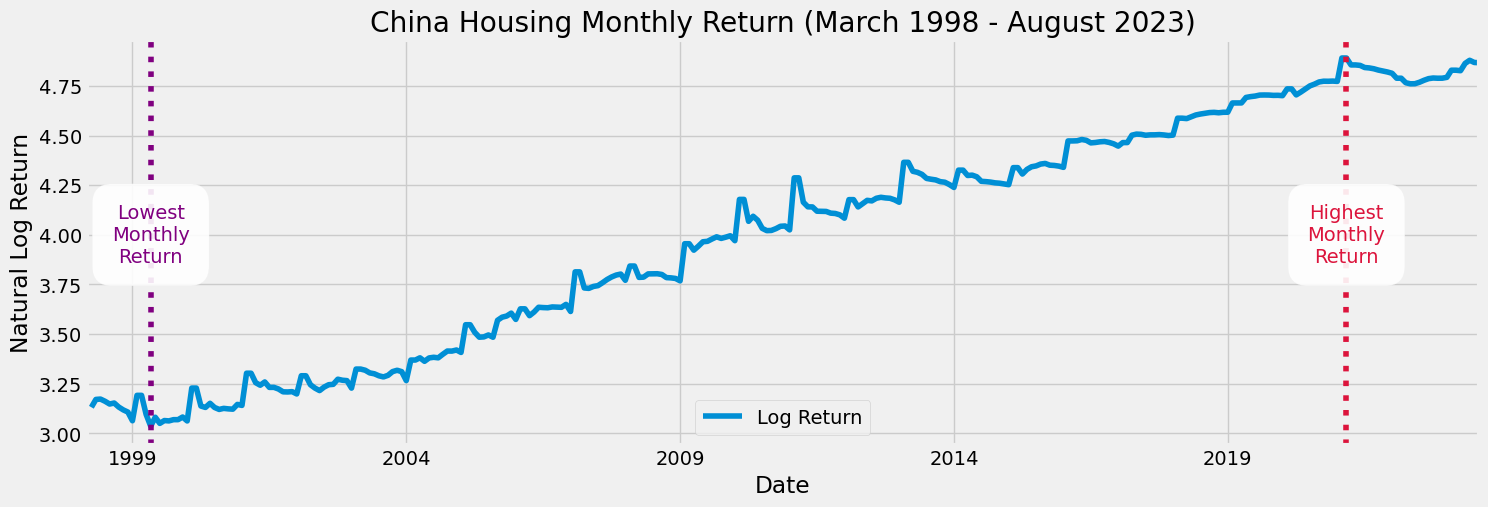

In [30]:
rpi_data['Log Return'].plot(figsize=(16,5))
plt.ylabel("Natural Log Return")
plt.xlabel("Date")
plt.title("China Housing Monthly Return (March 1998 - August 2023)")
plt.legend(loc="best")

event_list = [(pd.to_datetime('1999-05-31'), 'Lowest\nMonthly\nReturn', 'purple'),
             (pd.to_datetime('2021-03-31'), 'Highest\nMonthly\nReturn', 'crimson')]
for date_point, label, clr in event_list:
        plt.axvline(x=date_point, color=clr, linestyle=':')
        plt.text(x=date_point, y=4, s=label, horizontalalignment='center', verticalalignment='center',
                 color=clr, bbox=dict(facecolor='white', alpha=0.9, boxstyle='round, pad=1', linewidth=0.2))
        
plt.show()

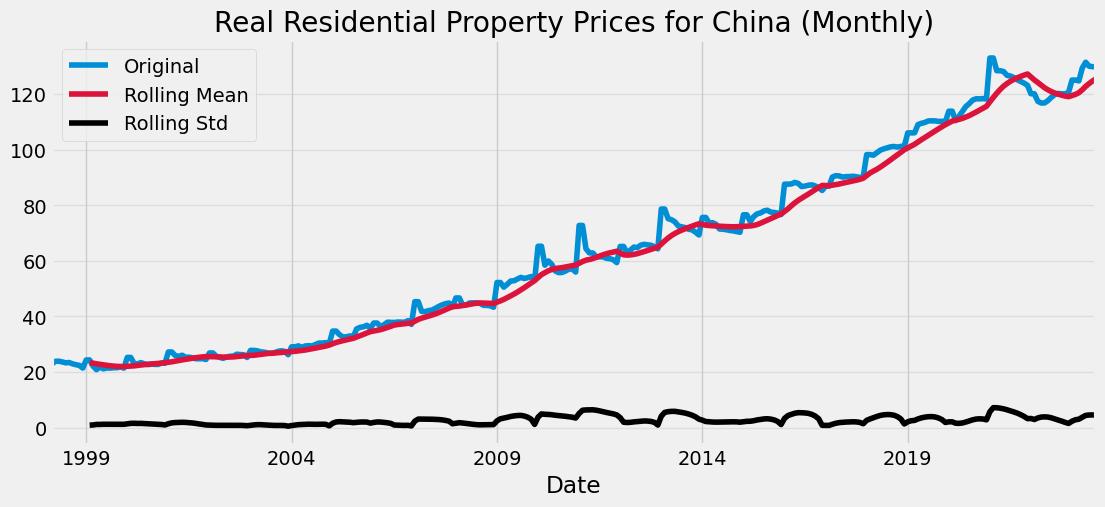

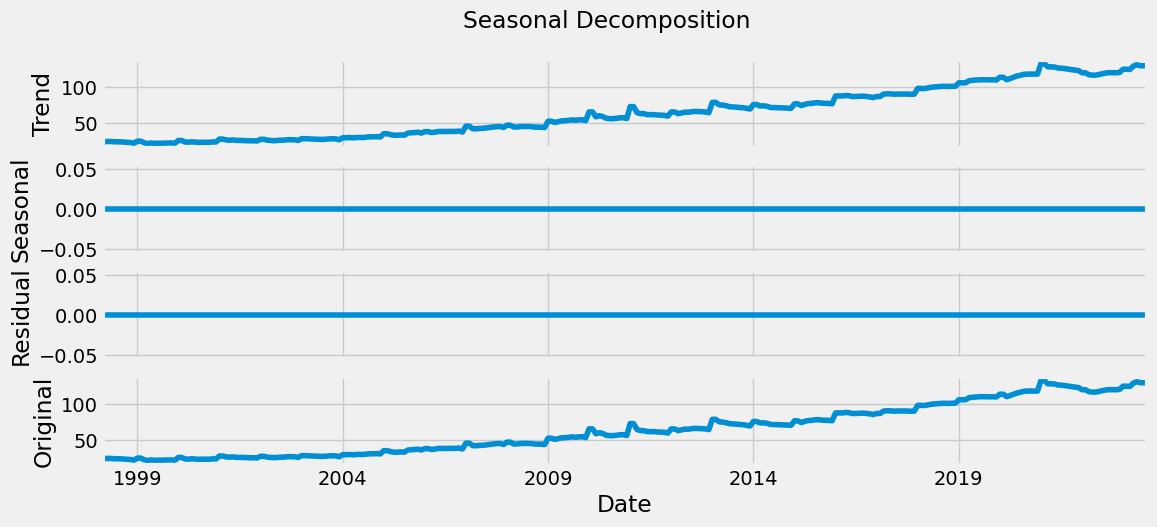

In [31]:
# visualize target data
def plot_time_series(series):
    mean_rolling = series.rolling(window=12).mean()
    std_rolling = series.rolling(window=12).std()
    
    # plot inflation rates
    series.plot(figsize=(12, 5), label='Original')
    mean_rolling.plot(color='crimson', label='Rolling Mean')
    std_rolling.plot(color='black', label='Rolling Std')
    plt.title('Real Residential Property Prices for China (Monthly)')
    plt.grid(axis='y', alpha=0.5)
    plt.legend(loc='best')
    plt.show()
    
    from statsmodels.tsa.seasonal import seasonal_decompose
    
    # plot decomposition components
    decomp = seasonal_decompose(series, model='additive', period = 1)
    fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 5))
    fig.suptitle('Seasonal Decomposition')
    
    decomp.trend.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Trend')
    
    decomp.seasonal.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Seasonal')
    
    decomp.resid.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Residual')
    
    decomp.observed.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Original')
    plt.show()

rpi_data = load_data(file_name='ChinaResidentialPropertyIndex_CEIC.xlsx')
plot_time_series(rpi_data['Rate'])

In [32]:
# ADF statistical test
def adf_test(series):
    from statsmodels.tsa.stattools import adfuller
    
    result = adfuller(series, regression='c', autolag='AIC')
    print('======= Augmented Dickey-Fuller Test Results =======\n')
    print('1. ADF Test Statistic: {:.6f}'.format(result[0]))
    print('2. P-value: {:.6f}'.format(result[1]))
    print('3. Used Lags: {}'.format(result[2]))
    print('4. Used Observations: {}'.format(result[3]))
    print('5. Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.6f}'.format(key, value))
    
    critical_value = result[4]['5%']
    if (result[1] <= 0.05) and (result[0] < critical_value):
        print('\nStrong evidence against the null hypothesis (H0), reject the null hypothesis.\
        Data has no unit root and is stationary.')
    else:
        print('\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.')
    return

# run function
adf_test(rpi_data['Rate'])

======= Augmented Dickey-Fuller Test Results =======

1. ADF Test Statistic: 1.004735
2. P-value: 0.994316
3. Used Lags: 13
4. Used Observations: 292
5. Critical Values:
	1%: -3.452945
	5%: -2.871490
	10%: -2.572071

Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.


In [33]:
# perform data transformation
# series: must be a pandas dataframe
def series_transformation(series):
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.tsa.stattools import adfuller
    
    # 1st plot - data after transformation
    fig = plt.figure(figsize=(16, 4))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_title('Transformed Series')
    ax1.plot(series)
    ax1.plot(series.rolling(window=12).mean(), color='crimson')
    ax1.plot(series.rolling(window=12).std(), color='black')
    
    # 2nd plot - partial autocorrelation plot
    ax2 = fig.add_subplot(1, 3, 2)
    plot_acf(series.dropna(), ax=ax2, lags=30, title='Autocorrelation')
    # plot 95% confidence intervals
    plt.axhline(y=-1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.axhline(y=1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.xlabel('lags')
    
    # 3rd plot - partial autocorrelation plot
    ax3 = fig.add_subplot(1, 3, 3)
    plot_pacf(series.dropna(), ax=ax3, lags=30, title='Partial Autocorrelation')
    plt.axhline(y=-1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.axhline(y=1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.xlabel('lags')
    plt.show()
    
    # ADF test
    result = adfuller(series.dropna(), regression='c', autolag='AIC')
    critical_value = result[4]['5%']
    if (result[1] <= 0.05) and (result[0] < critical_value):
        print('P-value = {:.6f}, the series is likely stationary.'.format(result[1]))
    else:
        print('P-value = {:.6f}, the series is likely non-stationary.'.format(result[1]))
    return

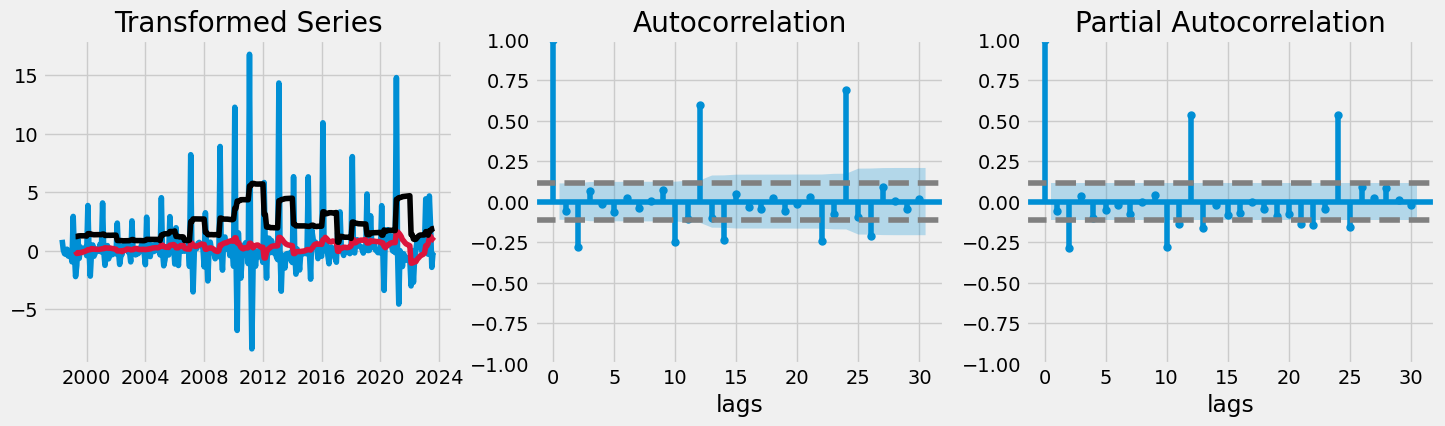

P-value = 0.000077, the series is likely stationary.


In [34]:
# first difference
series_transformation(rpi_data['Rate'].diff())

# Finding the relationship between Sentiment Index and Housing Prices

Text(0.5, 1.0, 'Housing Price Index and Sentiment Score: Oct 2021 – Oct 2023')

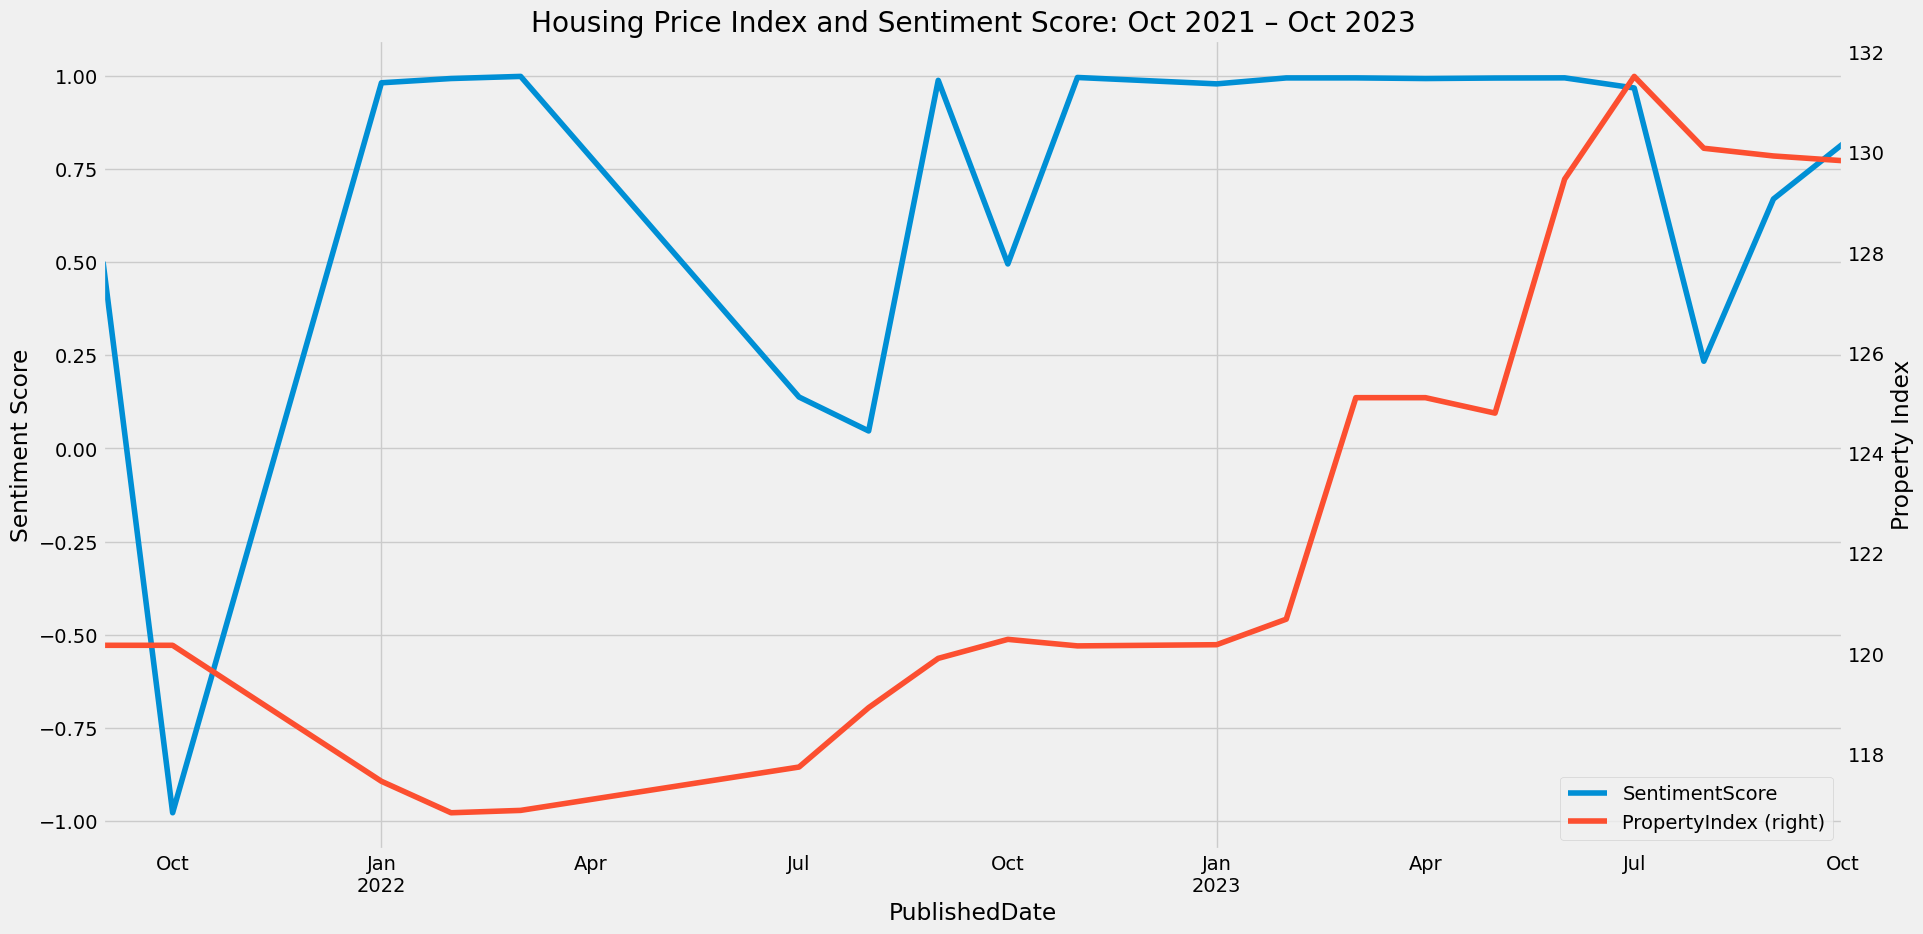

In [35]:
si_mean = sentiment_index.groupby('PublishedDate').compound.agg(['mean']).reset_index()
si_mean = si_mean.rename(columns={'mean':'SentimentScore'})
si_mean_monthly = si_mean.groupby(pd.PeriodIndex(si_mean['PublishedDate'], freq="M"))['SentimentScore'].mean().reset_index()
selected_month = rpi_data.loc['2022-01-01':'2023-09-01']

###

selected_month2 = selected_month.values.tolist()
# print(selected_month2)

rpi_list = []
for value in selected_month2:
    for item in value:
        rpi_list.append(item)
        
###

si_mean_monthly['PropertyIndex'] = rpi_list

###

fig, ax = plt.subplots(figsize=(20,10))
si_mean_monthly.plot(x='PublishedDate', y='SentimentScore', ax=ax, ylabel = "Sentiment Score")
si_mean_monthly.plot(x='PublishedDate', y='PropertyIndex', ylabel = "Property Index", ax=ax, secondary_y=True)
plt.title('Housing Price Index and Sentiment Score: Oct 2021 – Oct 2023')

In [36]:
corr = si_mean_monthly["SentimentScore"].corr(si_mean_monthly["PropertyIndex"], method='pearson')
print("Correlation between Sentiment Score and Property Index is: ", round(corr, 5))

Correlation between Sentiment Score and Property Index is:  0.13072
